In [102]:
import psycopg2
import nltk
from sklearn.feature_extraction.text import CountVectorizer
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import seaborn as sns
import string


### Establish a connection to the PostgreSQL database

In [2]:
params = {
    "host": "localhost",
    "port": 5432,
    "database": "Medhelp",
    "user": "postgres",
    "password": "qwe123!@#",
}
conn = psycopg2.connect(**params)
cur = conn.cursor()

### Fetch data

In [3]:
select_sql = """
    SELECT 
	    subj_title 
    FROM 
        question
    ORDER BY
        created_timestamp DESC
    LIMIT 
        50   
    OFFSET
        50
"""
cur.execute(select_sql)
subject_titles = cur.fetchall() # list of tuples

In [39]:
subject_titles

[('Varied BP numbers and high heart rate',),
 ('Why am I having episodes of severe hypertension?',),
 ('does any one have experience with Pravosin',),
 ('Dry Cough',),
 ('Taking propranolol, anxiety, and long-term effects.',),
 ('Buspirone and high blood pressure',),
 ('Struggling with High Blood Pressure',),
 ('Occasional high diastolic readings',),
 ('Effects lowering SYS BP  from 230 to Mid 150:',),
 ('lost weight on Losartan? ',),
 ('Coreg 25mg with or without food',),
 ('I’m obese with hypertension at 23 and not sure what next step is',),
 ('Anyone else get hypertension AFTER taking beta blockers?',),
 ('High and strange blood pressures.',),
 ('Blood pressure medication and Ibuprofen? ',),
 ("What's causing my BP spikes? (NOT pheochromocytoma)",),
 ('I had untreated hypertension in my mid 20s and now…..',),
 ('Poison from Desert Recluse Spider bite causing effects to hand and possible blood.',),
 ('Is this considered hypertension?',),
 ('Should I take BP med for white coat Syndrom

In [4]:
# Default token_pattern considers only words which have 2 or more alphanumerics as a token
# (punctuation is completely ignored and always treated as a token separator)
def preprocess_text(text):
    text = text.lower()
    text = re.sub(r'\b\d+\b', '', text)
    return text

title_list = [rec[0] for rec in subject_titles]
token_pattern = r"(?u)\b\w\w+\b"
# token_pattern = r"[^\W\d]+"
vect = CountVectorizer(preprocessor=preprocess_text,
                       analyzer="word",
                       ngram_range=(1, 1),
                       stop_words="english",
                       token_pattern=token_pattern)
X = vect.fit_transform(title_list)

### Create a co-occurrence matrix of unique words and initialize them to zero

In [121]:
# Set of unique words in the document
uniq_wrds = vect.get_feature_names_out().tolist()
print(uniq_wrds)
n = len(uniq_wrds)
co_mat = np.zeros(shape=(n, n))

['20s', '25mg', '27yo', 'advice', 'age', 'amlodipine', 'anxiety', 'appear', 'appropriate', 'barriers', 'beta', 'bite', 'blockers', 'blood', 'body', 'borderline', 'bought', 'bp', 'breath', 'brown', 'buspirone', 'case', 'cause', 'causing', 'chastity', 'coat', 'concern', 'concor', 'considered', 'control', 'coreg', 'cough', 'counter', 'crisis', 'day', 'days', 'desert', 'device', 'diastolic', 'does', 'doses', 'dry', 'edging', 'effects', 'elderly', 'emergency', 'episodes', 'essential', 'exercise', 'experience', 'face', 'feelings', 'food', 'hand', 'hands', 'having', 'hearing', 'heart', 'high', 'hypersensitive', 'hypertension', 'ibuprofen', 'increase', 'internal', 'irbesartan', 'long', 'loose', 'losartan', 'lost', 'lower', 'lowering', 'machines', 'male', 'managing', 'med', 'medication', 'medications', 'mg', 'mid', 'mono', 'nebivolol', 'new', 'night', 'normal', 'numbers', 'obese', 'occasional', 'odd', 'old', 'people', 'pheochromocytoma', 'pill', 'poison', 'possible', 'pravosin', 'pressure', 'pr

### Update of co-occurrence matrix elements

In [122]:
window_len = 2
def update_co_mat(sent: str):
    # Get all the words in the sentence
    sent = sent.translate(str.maketrans("", "", string.punctuation))
    wrd_list = sent.split(" ")
    
    for focus_wrd_idx, focus_wrd in enumerate(wrd_list):
        focus_wrd = focus_wrd.lower()
        if focus_wrd in uniq_wrds:
            # The focus word itself is considered to increase 
            # Every focus word appears in its own context, all the diagonal elements are incremented
            for contxt_wrd_idx in range(max(0, focus_wrd_idx - window_len),
                                        min(len(wrd_list), focus_wrd_idx + window_len)):
                if (contxt_wrd := wrd_list[contxt_wrd_idx].lower()) in uniq_wrds:
                    co_mat_row_idx = uniq_wrds.index(focus_wrd)
                    co_mat_col_idx = uniq_wrds.index(contxt_wrd)
                    co_mat[co_mat_row_idx][co_mat_col_idx] += 1

In [123]:
for tlt in title_list:
    if "20s" in tlt.lower():
        print(tlt)
        print(uniq_wrds)
    
    update_co_mat(sent=tlt)
# print("Co-occurrence Matrix: ")
# print(co_mat)

I had untreated hypertension in my mid 20s and now…..
['20s', '25mg', '27yo', 'advice', 'age', 'amlodipine', 'anxiety', 'appear', 'appropriate', 'barriers', 'beta', 'bite', 'blockers', 'blood', 'body', 'borderline', 'bought', 'bp', 'breath', 'brown', 'buspirone', 'case', 'cause', 'causing', 'chastity', 'coat', 'concern', 'concor', 'considered', 'control', 'coreg', 'cough', 'counter', 'crisis', 'day', 'days', 'desert', 'device', 'diastolic', 'does', 'doses', 'dry', 'edging', 'effects', 'elderly', 'emergency', 'episodes', 'essential', 'exercise', 'experience', 'face', 'feelings', 'food', 'hand', 'hands', 'having', 'hearing', 'heart', 'high', 'hypersensitive', 'hypertension', 'ibuprofen', 'increase', 'internal', 'irbesartan', 'long', 'loose', 'losartan', 'lost', 'lower', 'lowering', 'machines', 'male', 'managing', 'med', 'medication', 'medications', 'mg', 'mid', 'mono', 'nebivolol', 'new', 'night', 'normal', 'numbers', 'obese', 'occasional', 'odd', 'old', 'people', 'pheochromocytoma', 'pi

In [127]:
# for testing
co_mat_temp = co_mat[:40, :40]
uniq_wrds_temp = uniq_wrds[:40]

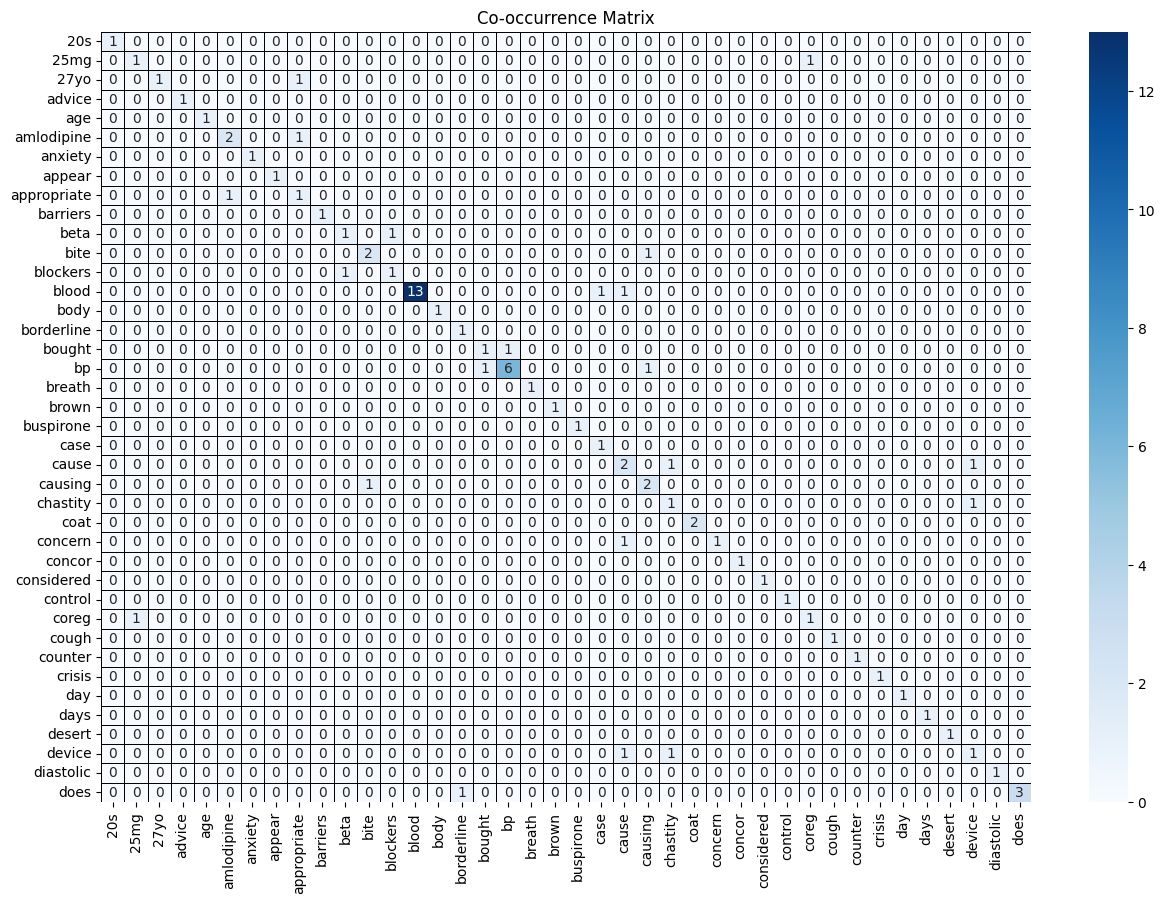

In [128]:
# Determine the size of the heatmap (in inches)
figure(figsize=(15, 10)) 
# Create a dataframe from the co-occurrence matrix uniq_wrds
df_cm1 = pd.DataFrame(co_mat_temp, index=uniq_wrds_temp, columns=uniq_wrds_temp)
cf_hm1 = sns.heatmap(data=df_cm1,
                     annot=True, # cell values should be displayed 
                     xticklabels=uniq_wrds_temp,
                     yticklabels=uniq_wrds_temp,
                     linewidths=0.5,
                     linecolor="black",
                     cmap="Blues" # colormap name
                     )
plt.yticks(rotation=0) # rotates the labels on the y-axis of the heatmap by 0 degrees
plt.title("Co-occurrence Matrix")
plt.show()


In [1]:
import collections

def co_occurrence_analysis(text):
  """محاسبه احتمال هم‌وقوع کلمات در متن
  Args:
    text: متن
  Returns:
    دیکشنری از کلمات و احتمال هم‌وقوع آن‌ها
  """

  # تبدیل متن به یک لیست از کلمات
  tokens = [x.strip() for x in text.split('،')]
  # print(tokens)
  # tokens = [token for idx, token in enumerate(tokens) if token not in tokens[:idx]]

  # محاسبه تعداد هم‌وقوع هر کلمه با کلمات دیگر
  co_occurrence_counts = collections.defaultdict(int)
  for i in range(len(tokens)):
    for j in range(i + 1, len(tokens)):
      co_occurrence_counts[(tokens[i].strip(), tokens[j].strip())] += 1
  # محاسبه احتمال هم‌وقوع هر کلمه
  co_occurrence_probabilities = {}
  for word, count in co_occurrence_counts.items():
    co_occurrence_probabilities[word] = count / len(tokens)

  return co_occurrence_probabilities

# مثال
text = "درد قفسه سینه، تنگی نفس، درد قفسه سینه، سرگیجه، درد قفسه سینه، تنگی نفس، درد قفسه سینه، تنگی نفس، کاهش وزن، خستگی، تب، سرفه، سر درد"
co_occurrence_probabilities = co_occurrence_analysis(text)
co_occurrence_probabilities

{('درد قفسه سینه', 'تنگی نفس'): 0.6153846153846154,
 ('درد قفسه سینه', 'درد قفسه سینه'): 0.46153846153846156,
 ('درد قفسه سینه', 'سرگیجه'): 0.15384615384615385,
 ('درد قفسه سینه', 'کاهش وزن'): 0.3076923076923077,
 ('درد قفسه سینه', 'خستگی'): 0.3076923076923077,
 ('درد قفسه سینه', 'تب'): 0.3076923076923077,
 ('درد قفسه سینه', 'سرفه'): 0.3076923076923077,
 ('درد قفسه سینه', 'سر درد'): 0.3076923076923077,
 ('تنگی نفس', 'درد قفسه سینه'): 0.3076923076923077,
 ('تنگی نفس', 'سرگیجه'): 0.07692307692307693,
 ('تنگی نفس', 'تنگی نفس'): 0.23076923076923078,
 ('تنگی نفس', 'کاهش وزن'): 0.23076923076923078,
 ('تنگی نفس', 'خستگی'): 0.23076923076923078,
 ('تنگی نفس', 'تب'): 0.23076923076923078,
 ('تنگی نفس', 'سرفه'): 0.23076923076923078,
 ('تنگی نفس', 'سر درد'): 0.23076923076923078,
 ('سرگیجه', 'درد قفسه سینه'): 0.15384615384615385,
 ('سرگیجه', 'تنگی نفس'): 0.15384615384615385,
 ('سرگیجه', 'کاهش وزن'): 0.07692307692307693,
 ('سرگیجه', 'خستگی'): 0.07692307692307693,
 ('سرگیجه', 'تب'): 0.0769230769230769

In [68]:
from collections import defaultdict

def calculate_cooccurrence(text):
  tokens = text.split('\n')
  tokens = [token for token in tokens if token != '']
  cooccurrence_counts = defaultdict(int)
  for i in range(len(tokens)):
    for j in range(i + 1, len(tokens)):
      cooccurrence_counts[(tokens[i], tokens[j])] += 1
  return cooccurrence_counts, len(tokens)

def calculate_collocation(cooccurrence_counts):
  """
  محاسبه احتمال همایندی کلمات
  Args:
    cooccurrence_counts: دیکشنری از احتمال هم‌وقوع کلمات
  Returns:
    دیکشنری از کلمات و احتمال همایندی آن‌ها
  """

  collocation_probabilities = {}
  for word_pair in list(cooccurrence_counts.keys()):
    count = cooccurrence_counts[word_pair]
    if count > 1:
      # محاسبه احتمال مشروط
      p_w1_given_w2 = count / (cooccurrence_counts[word_pair[1]] + 1)
      # محاسبه احتمال مشروط
      p_w2_given_w1 = count / (cooccurrence_counts[word_pair[0]] + 1)
      # محاسبه احتمال همایندی
      collocation_probabilities[word_pair] = p_w1_given_w2 * p_w2_given_w1
  return collocation_probabilities

# متن
text = """
سرطان
دیابت
سیستم ایمنی
سرطان
ویروس
سیستم ایمنی
سرطان
سیستم ایمنی
دیابت
سرماخوردگی
ویروس
"""

# محاسبه احتمال هم‌وقوع کلمات
cooccurrence_counts, total_words = calculate_cooccurrence(text)
# محاسبه احتمال همایندی کلمات
collocation_probabilities = calculate_collocation(cooccurrence_counts)

# چاپ جدول
print("کلمه\tهمایندی")
for word_pair, probability in collocation_probabilities.items():
  print(f"{word_pair[0]}\t{word_pair[1]}\t{probability}")


defaultdict(<class 'int'>, {('سرطان', 'دیابت'): 4, ('سرطان', 'سیستم ایمنی'): 6, ('سرطان', 'سرطان'): 3, ('سرطان', 'ویروس'): 5, ('سرطان', 'سرماخوردگی'): 3, ('دیابت', 'سیستم ایمنی'): 3, ('دیابت', 'سرطان'): 2, ('دیابت', 'ویروس'): 3, ('دیابت', 'دیابت'): 1, ('دیابت', 'سرماخوردگی'): 2, ('سیستم ایمنی', 'سرطان'): 3, ('سیستم ایمنی', 'ویروس'): 4, ('سیستم ایمنی', 'سیستم ایمنی'): 3, ('سیستم ایمنی', 'دیابت'): 3, ('سیستم ایمنی', 'سرماخوردگی'): 3, ('ویروس', 'سیستم ایمنی'): 2, ('ویروس', 'سرطان'): 1, ('ویروس', 'دیابت'): 1, ('ویروس', 'سرماخوردگی'): 1, ('ویروس', 'ویروس'): 1, ('سرماخوردگی', 'ویروس'): 1}) 11
11
کلمه	همایندی
سرطان	دیابت	16.0
سرطان	سیستم ایمنی	36.0
سرطان	سرطان	9.0
سرطان	ویروس	25.0
سرطان	سرماخوردگی	9.0
دیابت	سیستم ایمنی	9.0
دیابت	سرطان	4.0
دیابت	ویروس	9.0
دیابت	سرماخوردگی	4.0
سیستم ایمنی	سرطان	9.0
سیستم ایمنی	ویروس	16.0
سیستم ایمنی	سیستم ایمنی	9.0
سیستم ایمنی	دیابت	9.0
سیستم ایمنی	سرماخوردگی	9.0
ویروس	سیستم ایمنی	4.0
